In [3209]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import os

from parser import parse_filename, natural_sort
import pandas as pd

In [3210]:
ref_file = '/home/wanglei/hydrogen/analysis/refs/pnas2016.csv'
ref_df = pd.read_csv(ref_file, delimiter=r"\s+")
ref_df

,T,rs,etot,p,k,vtot
0,1200,1.34,-0.51592,269.0,NaN,NaN
1,1200,1.35,-0.51813,257.7,NaN,NaN
2,1200,1.36,-0.51980,243.1,NaN,NaN
3,1200,1.37,-0.52200,232.5,NaN,NaN
4,1200,1.38,-0.52560,234.1,NaN,NaN
5,1200,1.39,-0.52700,224.0,NaN,NaN
6,1200,1.40,-0.53010,218.5,NaN,NaN
7,1200,1.41,-0.53175,206.9,NaN,NaN
8,1200,1.42,-0.53353,198.5,NaN,NaN
9,1200,1.43,-0.53540,189.5,NaN,NaN


In [3242]:
T, rs = 1200, 1.
nicknames = ['jastrow-tabc-soft'] #, #, 'atom-positive-alpha', ] #'atom-exp-alpha'] #, #, 'atom-equivariant'] # 'atom']
files = []
for nickname in nicknames:
    files += glob("/data/wanglei/hydrogen/"+nickname+"/n_14*_dim_3_rs_%g*_T_%g_*depth_*spsize_*tpsize_*/data.txt"%(rs, T))
files = list(filter(lambda f: os.path.getsize(f)>100, files))
files = natural_sort(files)
len(files)

2

In [3246]:
def cond(f):
    n, dim, rs, T, s, d, h1, h2, b, a, lr, decay, eta, maxnorm, Nf, clip, K = parse_filename(f)
    return rs <1.46 and '_ht_' not in f #and 'mcp_0.001' not in f
files = list(filter(cond , files))
len(files)

2

/data/wanglei/hydrogen/jastrow-tabc-soft/n_14_dim_3_rs_1.34_T_1200_steps_1_depth_3_spsize_32_tpsize_16_Nf_5_K_4_Gmax_15_kappa_10_mctherm_10_mcsteps_100_100_mcwidth_0.01_0.05_lr_0.01_decay_0.01_damping_0.001_norm_0.001_clip_5_bs_1024_devices_1_accsteps_1/data.txt
/data/wanglei/hydrogen/jastrow-tabc-soft/n_14_dim_3_rs_1.44_T_1200_steps_1_depth_3_spsize_32_tpsize_16_Nf_5_K_4_Gmax_15_kappa_10_mctherm_10_mcsteps_100_100_mcwidth_0.01_0.05_lr_0.01_decay_0.01_damping_0.001_norm_0.001_clip_5_bs_1024_devices_1_accsteps_1/data.txt


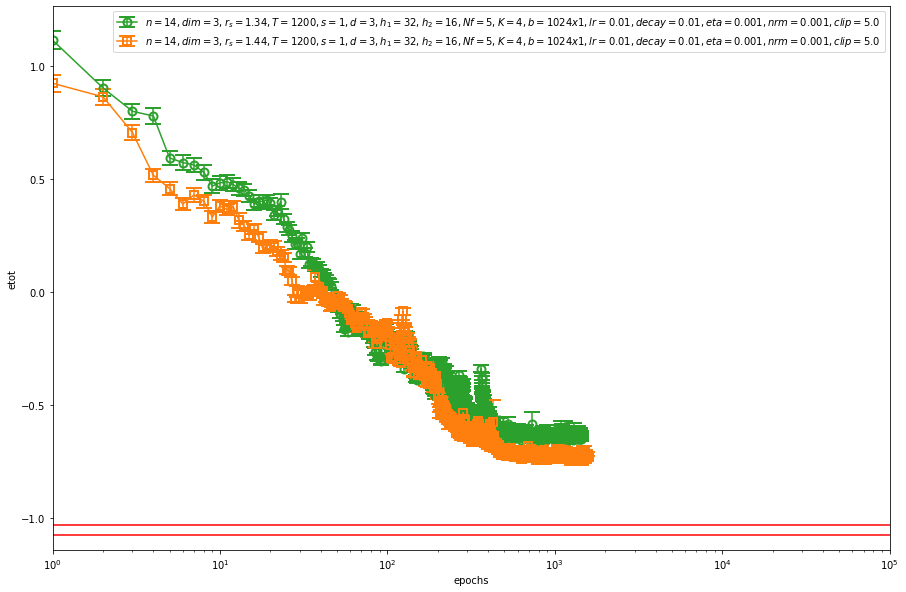

In [3249]:
obs = 'etot'

markers = ['o', 's', 'D', '*', 'x', '^', '<', 'h', '>', 'd', 'X', 'v', 'h', '1']
colors = ['C2', 'C1','C0', 'C3', 'C4', 'C6', 'C5', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13']

plt.figure(figsize=(15,10))
for f, marker, color in zip(files, markers, colors):
    n, dim, rs, T, s, d, h1, h2, b, a, lr, decay, eta, maxnorm, Nf, clip, K = parse_filename(f)
  
    print (f)
    df = pd.read_csv(f, delimiter=r"\s+")
    label = r'$n=%s,dim=%s,r_s=%s,T=%g,s=%s,d=%s,h_1=%s,h_2=%s,Nf=%s,K=%s,b=%sx%s,lr=%s,decay=%s,eta=%s,nrm=%s,clip=%s$'\
                %(n,dim,rs,T,s,d,h1,h2,Nf,K,b,a,lr,decay,eta,maxnorm,clip)
  
    if obs == 'vtot':
        y = df['vpp'].values + df['vep'].values + df['vee'].values
        yerr = np.sqrt(df['vpp_err'].values**2 + df['vep_err'].values**2 + df['vee_err'].values**2)       
    elif obs == 'etot':
        y = df['e'].values + df['vpp'].values
        yerr = np.sqrt(df['e_err'].values**2 + df['vpp_err'].values**2)
    elif obs in ['acc_s', 'acc_x']:
        y = df[obs].values
        yerr = np.zeros_like(y)
    else:
        y, yerr = df[obs].values, df[obs+'_err'].values
        
    plt.errorbar(df['epoch'].values, y, yerr=yerr,
                 marker=marker, color=color,markerfacecolor='none', 
                 markeredgewidth=2, ms=8, capsize=8, label=label)

    try:
        ref_value = ref_df.query('(T==%g) & (rs==%g)'%(T, rs))[obs].values[0]
        if obs in ['etot', 'k', 'vtot']: ref_value = 2*ref_value 
        plt.axhline(y=ref_value, color='r')
                
    except KeyError or IndexError:
        print ('no ref data')
        
    if obs == 'p': plt.ylim([0, 1000])
    #if obs in ['k', 'f', 'etot', 'e']: plt.ylim([-2, 1])
    
plt.legend(loc='best')
plt.ylabel(obs)
plt.xlabel('epochs')
plt.xlim([1, 1e5])
plt.xscale('log') 
#plt.ylim([-10, 10])

In [3235]:
import sys, os
sys.path.append("/home/wanglei/hydrogen/src")
from checkpoint import find_ckpt_filename, load_data

/data/wanglei/hydrogen/jastrow-tabc-soft/n_14_dim_3_rs_1.34_T_1200_steps_1_depth_3_spsize_32_tpsize_16_Nf_5_K_4_Gmax_15_kappa_10_mctherm_10_mcsteps_100_100_mcwidth_0.01_0.05_lr_0.01_decay_0.01_damping_0.001_norm_0.001_clip_5_bs_1024_devices_1_accsteps_1/epoch_001440.pkl


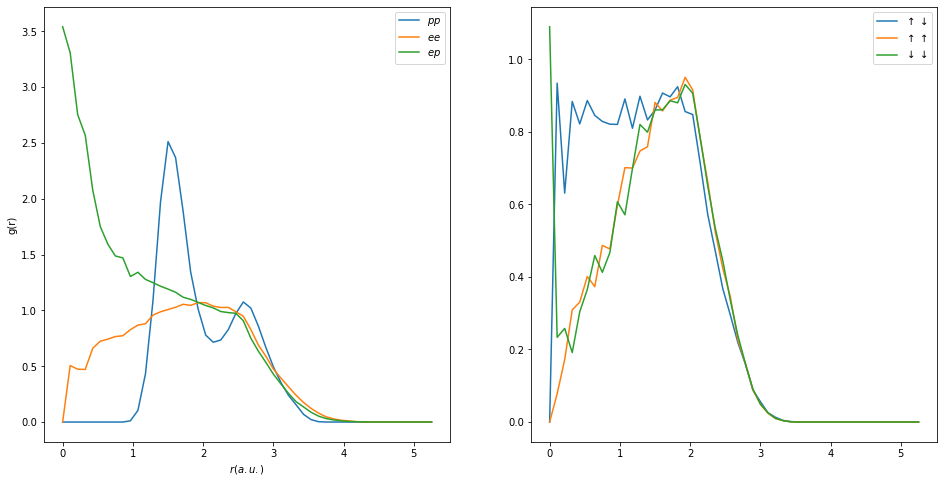

In [3245]:
def get_gr(x, y): 
    batchsize, n, dim = x.shape[0], x.shape[1], x.shape[2]
    
    if dim == 3:
        L = (4/3*np.pi*n)**(1/3)
    elif dim == 2:
        L = np.sqrt(jnp.pi*n)
        
    i,j = np.triu_indices(n, k=1)
    rij = (np.reshape(x, (-1, n, 1, dim)) - np.reshape(y, (-1, 1, n, dim)))[:,i,j]
    rij = rij - L*np.rint(rij/L)
    dist = np.linalg.norm(rij, axis=-1) # (batchsize, n*(n-1)/2)
    
    hist, bin_edges = np.histogram(dist.reshape(-1,), range=[0, 4], bins=50)
    dr = bin_edges[1] - bin_edges[0]
    hist = hist*2/(n * batchsize)

    rmesh = np.arange(hist.shape[0])*dr
    h_id = 4/3*np.pi*n/(L**3)* ((rmesh+dr)**3 - rmesh**3 )
    return rmesh, hist/h_id


fig = plt.figure(figsize=(16, 8))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

for f in [files[0]]:
    n, dim, rs, T, s, d, h1, h2, b, a, lr, decay, eta, maxnorm, Nf, clip, K = parse_filename(f)
    
    ckpt_file, _ = find_ckpt_filename(os.path.dirname(f))
    if ckpt_file is None: continue
    print (ckpt_file)
    data = load_data(ckpt_file)
    
    s, x = data['s'], data['x']
    n, dim = x.shape[-2], x.shape[-1]
    s = s.reshape(-1, n, dim)
    x = x.reshape(-1, n, dim)

    rmesh, gr = get_gr(s, s)
    ax1.plot(rmesh*rs, gr, label=r'$pp$')
    rmesh, gr = get_gr(x, x)
    ax1.plot(rmesh*rs, gr, label=r'$ee$')
    rmesh, gr = get_gr(s, x)
    ax1.plot(rmesh*rs, gr, label=r'$ep$')
    

    rmesh, gr = get_gr(x[:, :n//2], x[:, n//2:])
    ax2.plot(rmesh*rs, gr, label=r'$\uparrow\downarrow$')
    rmesh, gr = get_gr(x[:, :n//2], x[:, :n//2])
    ax2.plot(rmesh*rs, gr, label=r'$\uparrow\uparrow$')
    rmesh, gr = get_gr(x[:, n//2:], x[:, n//2:])
    ax2.plot(rmesh*rs, gr, label=r'$\downarrow\downarrow$')
      
    
ax1.set_xlabel('$r(a.u.)$')
ax1.set_ylabel('g(r)')
ax1.legend()
ax2.legend()   


/data/wanglei/hydrogen/jastrow-tabc-soft/n_14_dim_3_rs_1.34_T_1200_steps_1_depth_3_spsize_32_tpsize_16_Nf_5_K_4_Gmax_15_kappa_10_mctherm_10_mcsteps_100_100_mcwidth_0.01_0.05_lr_0.01_decay_0.01_damping_0.001_norm_0.001_clip_5_bs_1024_devices_1_accsteps_1/epoch_001401.pkl


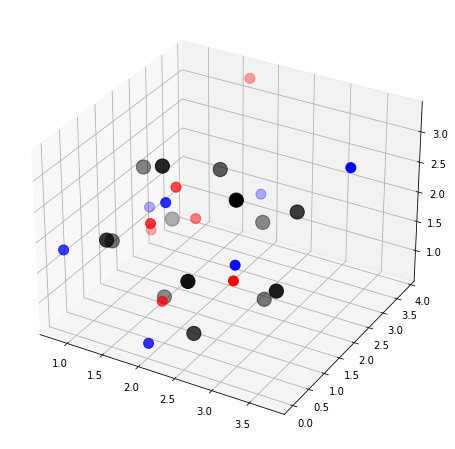

In [3238]:
f = files[0]
n, dim, rs, T, s, d, h1, h2, b, a, lr, decay, eta, maxnorm, Nf, clip, K = parse_filename(f)
    
ckpt_file, _ = find_ckpt_filename(os.path.dirname(f))

print (ckpt_file)
data = load_data(ckpt_file)
    
s, x = data['s'], data['x']
n, dim = x.shape[-2], x.shape[-1]
s = s.reshape(-1, n, dim)
x = x.reshape(-1, n, dim)


fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(projection='3d')

b = 1

ax.scatter(s[b, :, 0], s[b, :, 1], s[b, :, 2], marker='o', color='k', s=200)
ax.scatter(x[b, :n//2, 0], x[b, :n//2, 1], x[b, :n//2, 2], marker='o', color='r', s=100)
ax.scatter(x[b, n//2:, 0], x[b, n//2:, 1], x[b, n//2:, 2], marker='o', color='b', s=100)


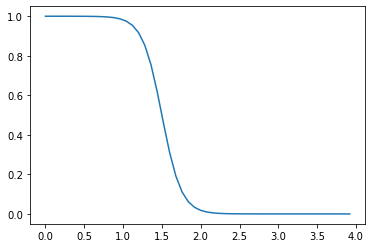

In [3239]:
def gc(r):
     return (np.tanh(-4*(r-1.5))+1)/2
plt.plot(rmesh, gc(rmesh))

In [3243]:
for f in files:
    
    n, dim, rs, T, s, d, h1, h2, b, a, lr, decay, eta, maxnorm, Nf, clip, K = parse_filename(f)
    
    ckpt_file, _ = find_ckpt_filename(os.path.dirname(f))

    print (ckpt_file)
    data = load_data(ckpt_file)
    
    s, x = data['s'], data['x']

    n, dim = x.shape[-2], x.shape[-1]
    s = s.reshape(-1, n, dim)
    x = x.reshape(-1, n, dim)
    batchsize = x.shape[0]
    
    rij = (np.reshape(s, (-1, n, 1, dim)) - np.reshape(s, (-1, 1, n, dim)))
    rij = rij - L*np.rint(rij/L)
    r = np.linalg.norm(rij, axis=-1)
    r = r + 1e10*np.eye(n, n)[None, ...]

    print (rs, np.mean(gc(rs*np.min(r, axis=-1))))

/data/wanglei/hydrogen/jastrow-tabc-soft/n_14_dim_3_rs_1.34_T_1200_steps_1_depth_3_spsize_32_tpsize_16_Nf_5_K_4_Gmax_15_kappa_10_mctherm_10_mcsteps_100_100_mcwidth_0.01_0.05_lr_0.01_decay_0.01_damping_0.001_norm_0.001_clip_5_bs_1024_devices_1_accsteps_1/epoch_001401.pkl
1.34 0.5852925722876233
/data/wanglei/hydrogen/jastrow-tabc-soft/n_14_dim_3_rs_1.44_T_1200_steps_1_depth_3_spsize_32_tpsize_16_Nf_5_K_4_Gmax_15_kappa_10_mctherm_10_mcsteps_100_100_mcwidth_0.01_0.05_lr_0.01_decay_0.01_damping_0.001_norm_0.001_clip_5_bs_1024_devices_1_accsteps_1/epoch_001517.pkl
1.44 0.4019895067866465


6.092947785379555


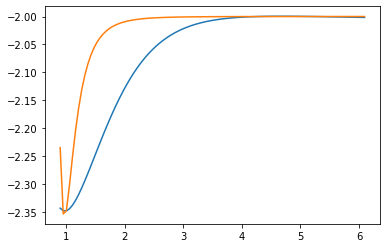

In [2716]:
rs = 1.44 
n = 54 
L = (4/3*np.pi*n)**(1/3)
print (L)

p = jnp.array([-1.0, 2.867, -5.819, -9.935, 4.456])
q = jnp.array([1.0, -3.005, 7.81, 2.104, 0.4839])

r = jnp.linspace(0.9, L, 100)
v = jnp.polyval(p, r*rs)/ jnp.polyval(q, r*rs)*2
plt.plot(r, v)

epsilon = 2*0.18 
sigma = 1.4/rs/(2**(1/6)) 
v = 4*epsilon*((sigma/r)**12 - (sigma/r)**6) -2 
plt.plot(r, v)